#  End to end machine learning model for housing prices.


- This is a practice project where an end to end ML model is deployed for predicting **housing prices**  based on  the California Housing Prices dataset from the StatLib repository2. This dataset is based on data from the 1990 California census. 
- The project follows more or less the same structure given in Chaper 2 of “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, by Aurélien Géron (O’Reilly). Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9.”
- Includes tips on starting on a ML project with real data. 
- Fits 3 different regression models:  
    1) Linear reg model based on OLS.  
    2) Ordinary Decision Tree technique.  
    3) Random forest decision trees. 
- Spends significant time on data visualization, cleaning, transformation pipelines.
- Used hyper-parameter tuning and cross validation techniques to get the best model out of the three models considered.
- Final model, after selection through tuning and rmse error comparisons are saved in the "./saved_models/final_model.pkl" can easily be loaded using :
```
import joblib
final_model_loaded = joblib.load
```

    

## Checking all the dependencies for the project

In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# importing matplotlib for plotting and figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Importing the data from the remote server

In [2]:
import os
import tarfile
import urllib

HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"

def download_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
download_housing_data()


## Function to load data to pandas automatically

In [3]:
import pandas as pd

#function to load data automatically as a panda dataframe
def load_data_to_panda(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

#housing pandas data frame
housing_df = load_data_to_panda()
# print(housing_df.shape)
housing_df.head()
# print(housing_df.info())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
#Looking at the dataframe information
print(housing_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [5]:
#Looking at categorical values for ocean proximity attribute
housing_df["ocean_proximity"].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## Looking at the stat description of the data

In [6]:
#Looking at the stat description of the data
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
#Looking at only the pricing description
housing_df["median_house_value"].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

## Plotting histogram for whole data set

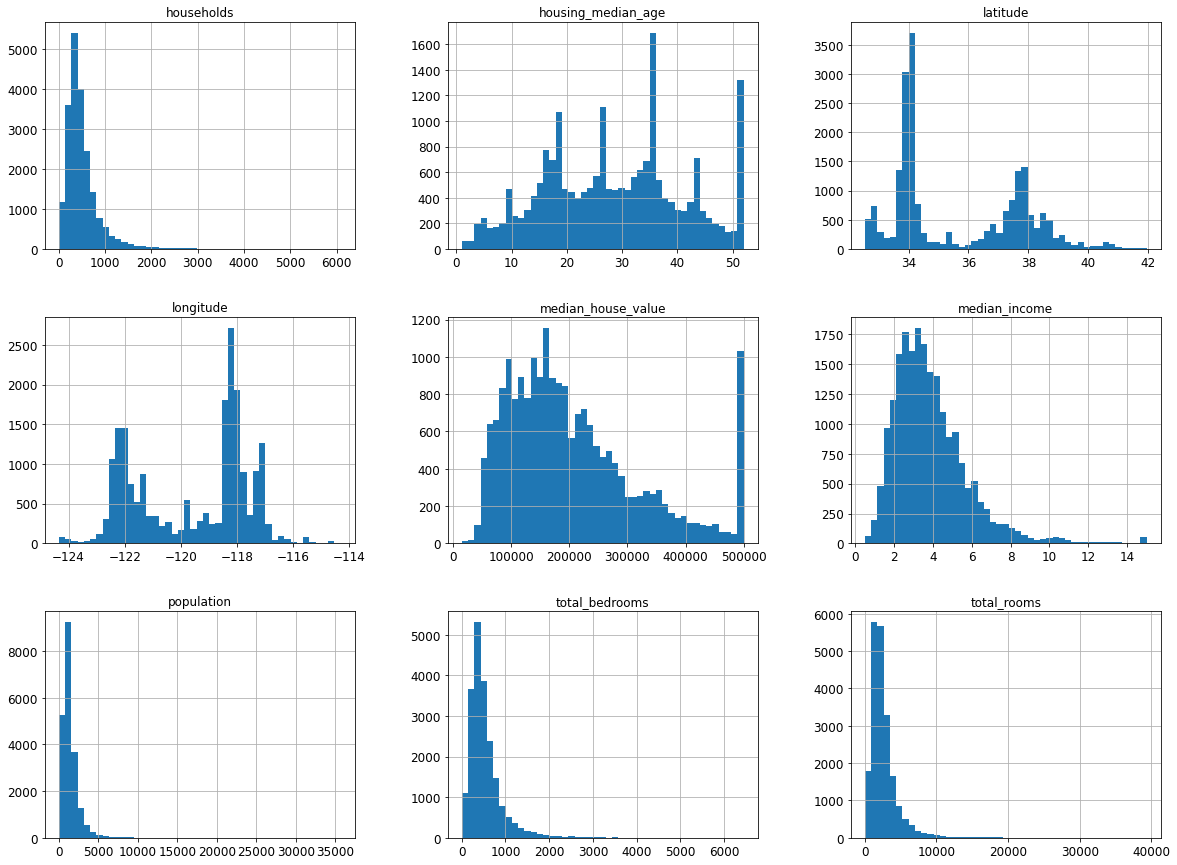

In [8]:
#Plotting histogram for whole data set
%matplotlib inline
import matplotlib.pyplot as plt
housing_df.hist(bins=45, figsize=(20,15))
plt.show()

## Plotting only one attribute

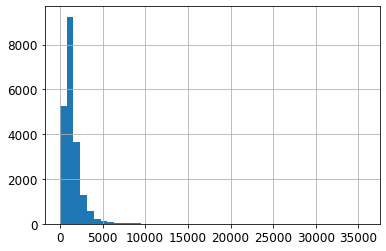

In [9]:
# plt.hist(housing_df["population"],bins=50)
housing_df["population"].hist(bins=45)

## Splitting the data to training and testing sets
Note that here we uses originary validaiton approach: and not cross-validation. But its a good idea to use cross-validation instead, whenever the data set is not very big.

### Normal random sampling without stratificaition

In [10]:
housing_df_with_id = housing_df.reset_index() #adding a new column named 'index' with row indices

housing_df_with_id['id'] = housing_df['longitude']*1000 + housing_df['latitude']

#We can just use the sklearn function to split the dataset
from sklearn.model_selection import train_test_split
#train_test_split to split to test and train sets. test_size is the portion of test set(20%),
#random_state is fix the random seed to get consistent recurrent results.
training_set, testing_set = train_test_split(housing_df, test_size=0.2, random_state=42)


### Using stratificaiton based on median_income since this seems to be an important factor governing the house pricing
WE start by stratifying the data set into subgroups or strata based on median_income(5 different strata in our case). 
WE use the pd.cut()function to do this. 

In [11]:
housing_df["income_category"] = pd.cut(housing_df["median_income"],
                                      bins=[0.,1.5,3.,4.5,6.,np.inf],
                                       labels=[1,2,3,4,5])
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


### We now use the StratifiedShuffleSplit function from sklearn.model_selection

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_df, housing_df["income_category"]):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]
strat_test_set["income_category"]
strat_test_set["income_category"]

5241     5
10970    4
20351    3
6568     3
13285    3
        ..
20519    2
17430    2
4019     4
12107    4
2398     3
Name: income_category, Length: 4128, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

### Getting rid of the income category from the data sets

In [18]:
strat_train_set.drop("income_category", axis=1, inplace=True)
strat_test_set.drop("income_category", axis=1, inplace=True)

## Visualizing data manually to get insights and discover patters

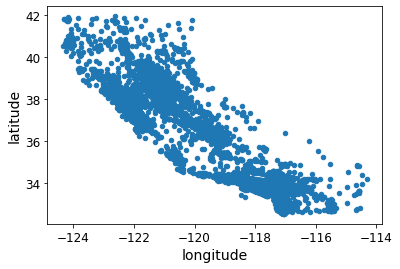

In [21]:
housing_df = strat_train_set.copy()
# plt.scatter("longitude","latitude",data=housing_df) Using the matplotlib basic commands
housing_df.plot(kind="scatter", x="longitude", y="latitude")


Saving figure scatter_plot_longvslat


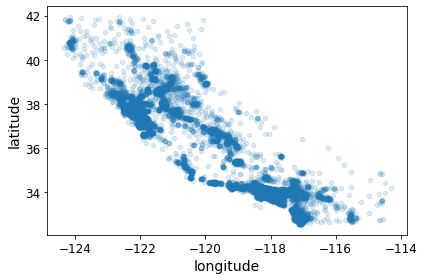

In [26]:
#Better visualizing by decreasing alpha(and hence increasing transparency)
housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.15)

save_fig("scatter_plot_longvslat") # saving using function written earlier
#Note that the function call is replacing the following command:
#plt.savefig("./images/scatter_plot_longvslat.png", format=png, dpi=resolution)

### Scatter plots with more colors and more information incorporated
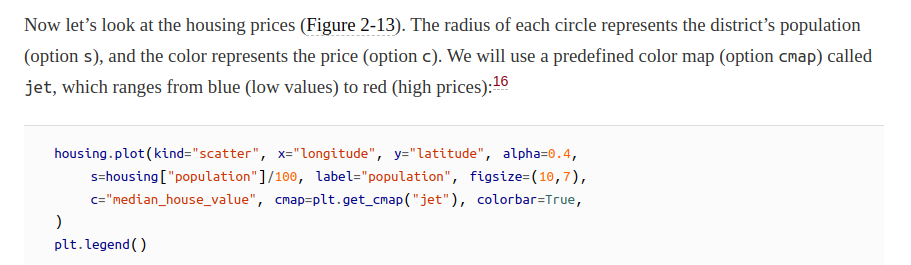

Saving figure improved scatter


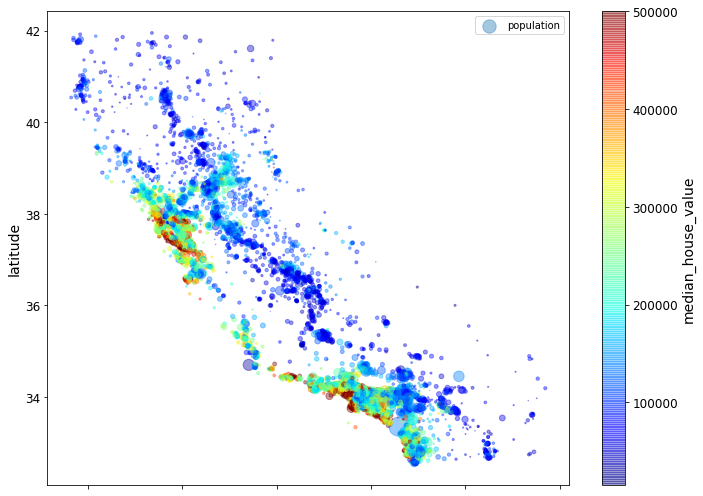

In [37]:
housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
               s=housing_df["population"]/100, label="population", figsize=(10,7),
               c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
save_fig("improved scatter")


## Finding correlations

### Using pearsons'r or standard correlation coefficient 
which lies between -1 and 1, -1 negative correlation, +1: positive correlation.
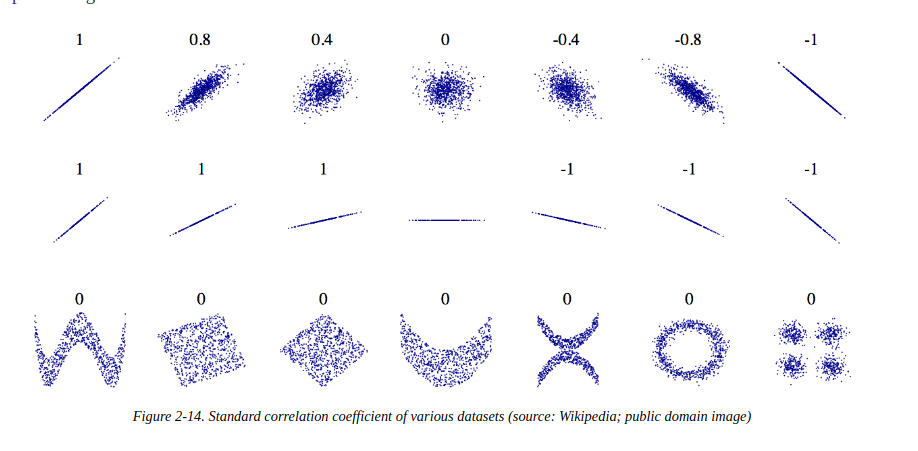
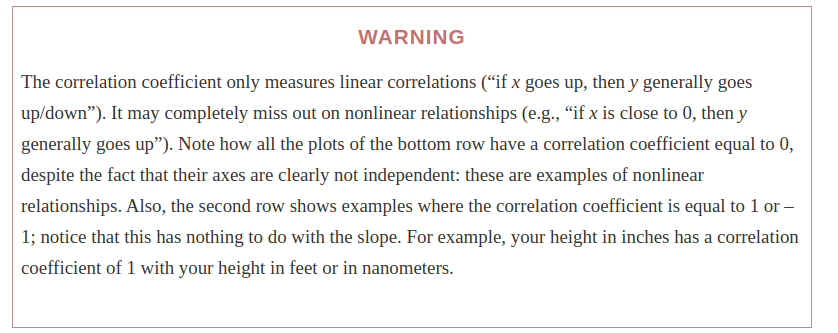

In [76]:
cor_matrix = housing_df.corr() #correlation matrix
most_correalted = cor_matrix["median_house_value"].sort_values(ascending=False)
most_correalted #most correlated attributes to median_house_value
most_correalted[:4].index

Index(['median_house_value', 'median_income', 'total_rooms',
       'housing_median_age'],
      dtype='object')

### Plotting significant attributes(columns) against each other
This can be done using pandas scatter_matrix

Saving figure scatter_matrix


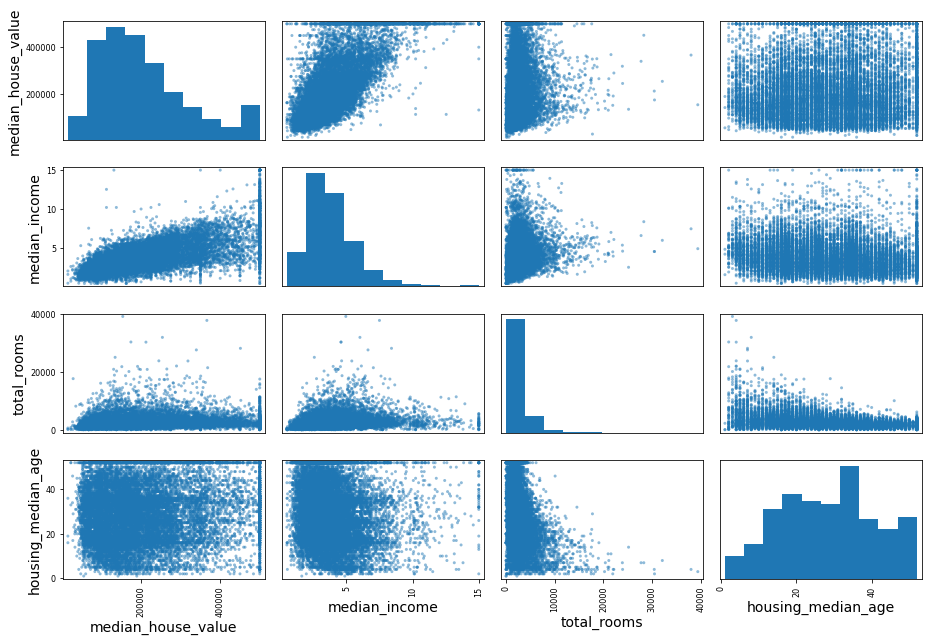

In [79]:
from pandas.plotting import scatter_matrix

attributes = most_correalted[:4].index
#above line is replacing attributes = ["median_house_value", "median_income", "total_rooms",
#              "housing_median_age"]
scatter_matrix(housing_df[attributes],figsize=(13,9))
save_fig('scatter_matrix')

### Plotting median_house_value against most siginificant(correlated) attribute
which is median_income

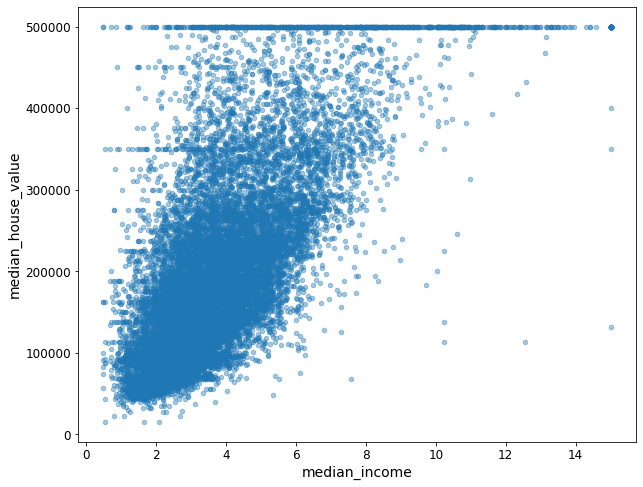

In [83]:
housing_df.plot(kind="scatter",x="median_income", y="median_house_value",
               alpha =0.4, figsize=(10,8))

## Adding additional (possibly useful) attributes to dataframe

In [ ]:
housing_df["rooms_per_household"] = housing_df["total_rooms"]/housing_df["households"]
housing_df["bedrooms_per_room"] = housing_df["total_bedrooms"]/housing_df["total_rooms"]
housing_df["population_per_household"]=housing_df["population"]/housing_df["households"]


### Checking correlation matrix again to make sure the new attributes are indeed useful

In [85]:
correlation_matrix = housing_df.corr()
correlation_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

## Preparing the data before feeding to ML algorithms

### We start by separating the predictors and labels 
since we might want to apply different kind of transformations to them.

In [88]:
housing_df = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


pandas.core.series.Series

### Data cleaning
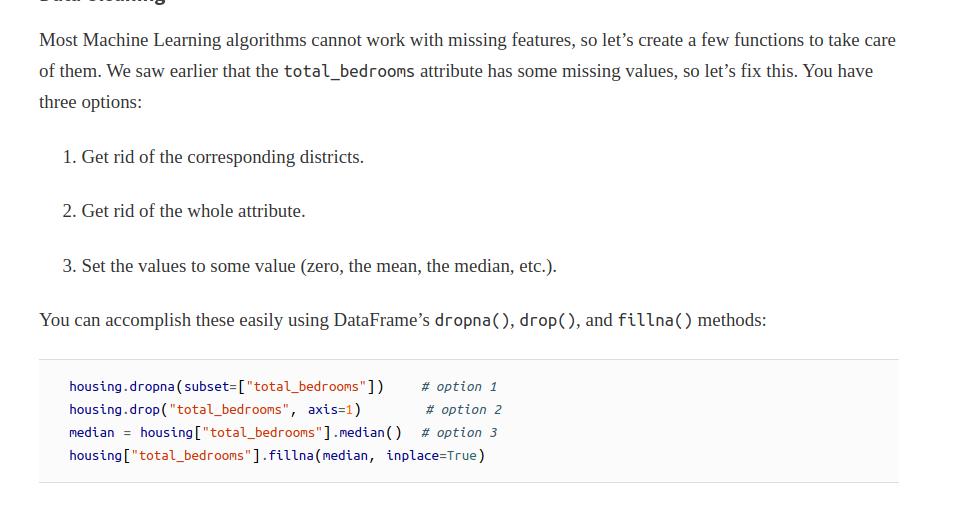


### using scikit-learn method to compute and save median of each attribute

In [94]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing_df.drop("ocean_proximity", axis=1) #taking only the numerical attribute
imputer.fit(housing_num)
print(imputer.statistics_) 
#imputer.statistics is same as housing_num.median().values()

X = imputer.transform(housing_num) #replacing missing(na) with meddian values
#above X is a simple nd Numpy array. We can change it to pandas df:
housing_tr  = pd.DataFrame(X, columns = housing_num.columns, index= housing_num.index)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


### Handling text and categorical attributes

In [99]:
housing_cat = housing_df[["ocean_proximity"]]
print(type(housing_cat))


from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

<class 'pandas.core.frame.DataFrame'>


array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

### Using dummy attributes to take care of categorical variables

In [100]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [101]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom transformer class
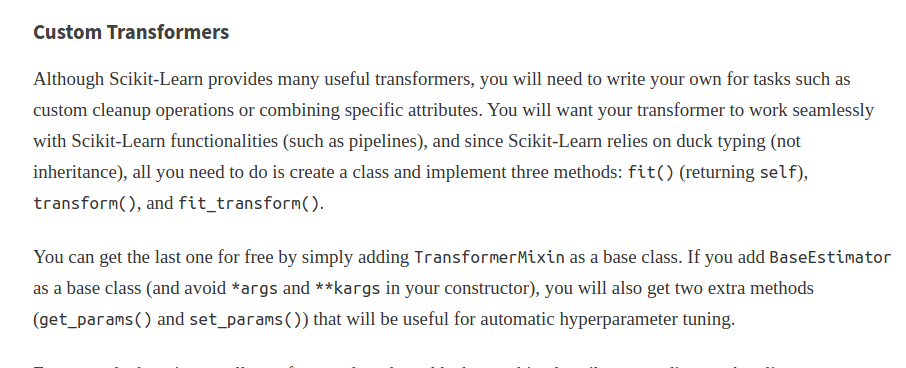

In [103]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_df.values)

### Feature scaling 

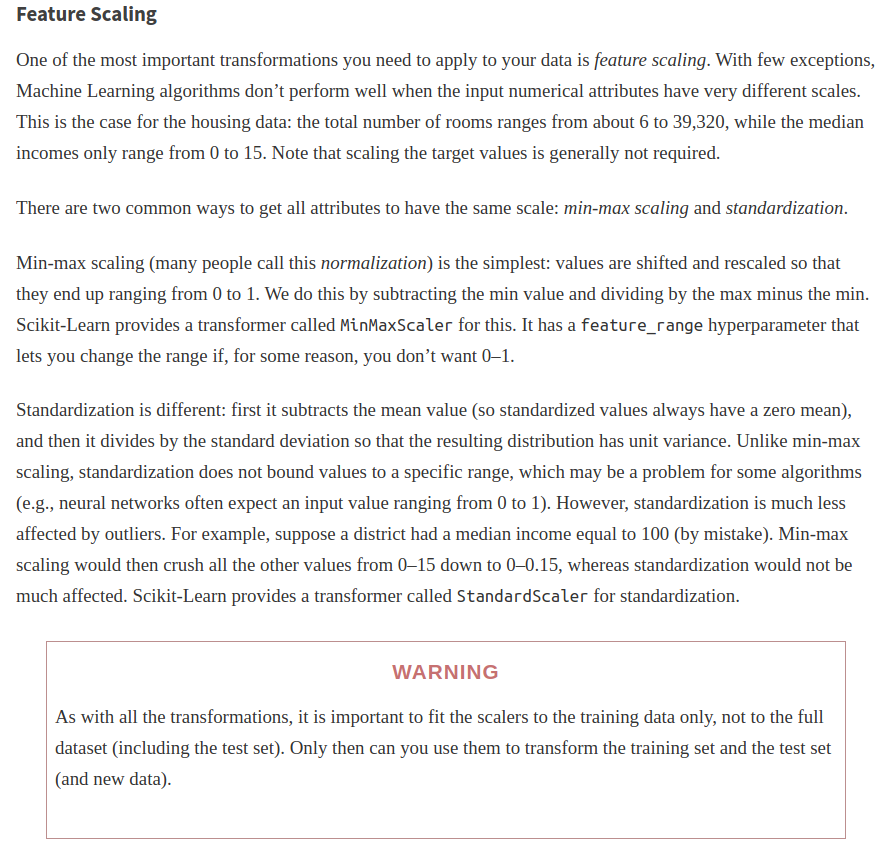

### Transformatin pipelines using scikit-learn class

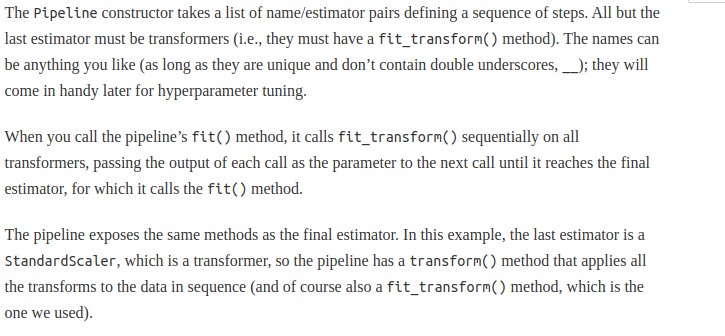

In [106]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                        ('imputer', SimpleImputer(strategy="median")),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler',StandardScaler())
                        ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

### Column transfer to put transformer columns together
and also to decide which columns should be transformed.
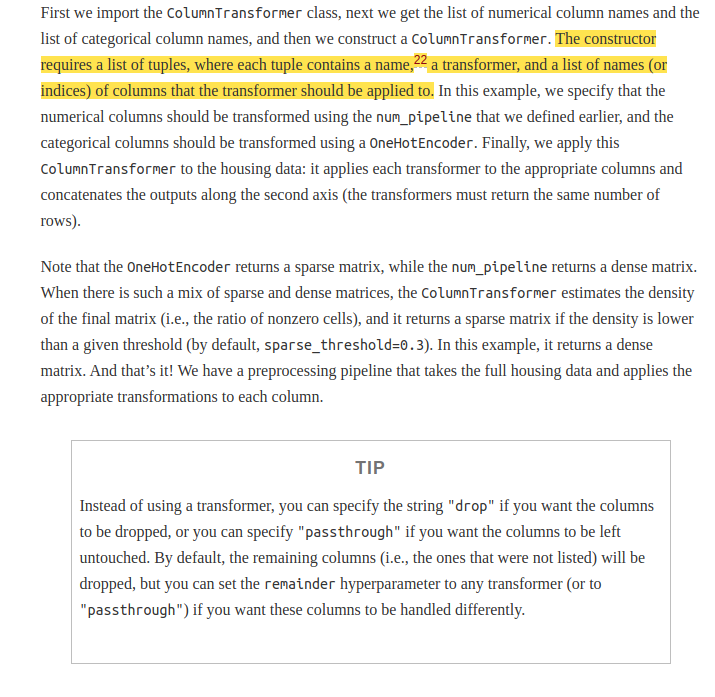

In [119]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num) #getting list of column labels of housing_num
#above line can be replaced by num_attribs = list(housing_num.columns)
categ_atribs = ["ocean_proximity"]

complete_pipleline = ColumnTransformer([
                                       ("num", num_pipeline, num_attribs),
                                       ("categ", OneHotEncoder(), categ_atribs)
                                       ])


### Finally we are doing all the transformations going through a single popleline ,
doing transformations one after the other to get prepared housing data

In [129]:
housing_prepared_df = complete_pipleline.fit_transform(housing_df)

## Model selection and Training 

## Training and evaluation on the training set 

### Linear Model 

In [131]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(housing_prepared_df, housing_labels)

LinearRegression()

In [144]:
#Initial testing of the model on training set
part_of_train_data = housing_df.iloc[10:16]
corresponding_train_label = housing_labels.iloc[10:16]
part_of_train_data_prepared = complete_pipleline.transform(part_of_train_data)
print("first set of predictions:\n",linear_reg.predict(part_of_train_data_prepared))
print("expected labels:\n",list(corresponding_train_label))

first set of predictions:
 [118169.92762422  87365.82163318 320675.82421293 127808.84524184
 125545.49305265 204198.01305268]
expected labels:
 [92100.0, 61500.0, 313000.0, 89000.0, 123900.0, 197400.0]


### Testing the training RMSE using scikit-learn package

In [169]:
from sklearn.metrics import mean_squared_error

all_housing_train_pred = linear_reg.predict(housing_prepared_df)
linear_train_mse = mean_squared_error(housing_labels,all_housing_train_pred)
linear_train_mse = np.sqrt(linear_train_mse)
print(linear_train_mse)

#can also be found using 
error_diff = all_housing_train_pred - housing_labels
error_diff = error_diff*error_diff
mse_array = np.sqrt(error_diff.sum()/housing_labels.size)
print(mse_array   )

68628.19819848923
68628.19819848923


### Using ordinary decision tree regression


In [173]:
from sklearn.tree import DecisionTreeRegressor

ord_tree_regressor = DecisionTreeRegressor()
ord_tree_regressor.fit(housing_prepared_df,housing_labels)

#Calculating training mse for the decision tree
all_housing_train_pred_tree = ord_tree_regressor.predict(housing_prepared_df)
tree_train_mse = np.sqrt(mean_squared_error(all_housing_train_pred_tree,housing_labels))
tree_train_mse

#We are obviously overfitting data here



0.0

## Using cross validation
to make sure that we are not overfitting data.
WE use K-fold corss validation approach. For that we can make use of sckit-learns built-in function.

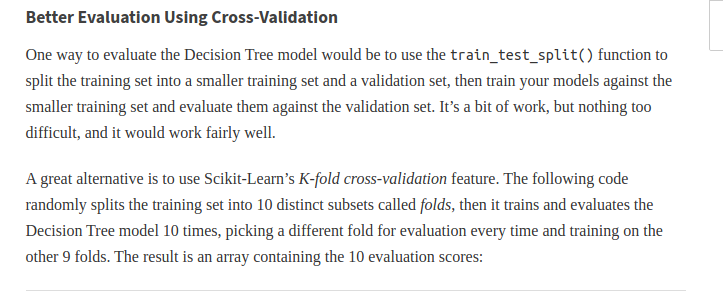

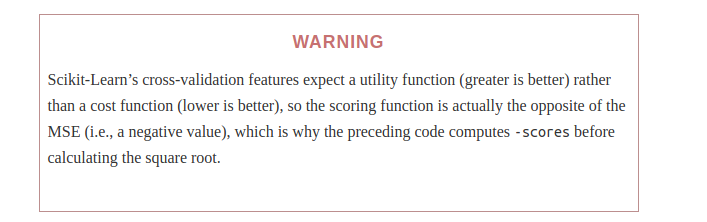

In [178]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(ord_tree_regressor, housing_prepared_df, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_train_mse_scores_crossva = np.sqrt(-scores)
tree_train_mse_scores_crossva # this will give 10(since cv=10) cross validated 
#mse with respect to different folds used as as test set

array([68317.59859747, 67929.06607157, 70107.4844752 , 68201.51948191,
       73039.54209323, 75413.44967848, 69557.53536565, 71991.89453196,
       76235.36082196, 70238.2842852 ])

In [185]:
#We can  better visualize the cv mse using the followig function:
def display_scores(mse_scores):
    print("mse scores:\n" ,", ".join(map(str,mse_scores)))
    print("mean:", mse_scores.mean())
    print("std: ", mse_scores.std())

display_scores(tree_train_mse_scores_crossva)

mse scores:
 68317.59859746753, 67929.06607157155, 70107.48447520382, 68201.5194819106, 73039.54209323178, 75413.44967848138, 69557.53536564927, 71991.89453195702, 76235.36082195814, 70238.28428520227
mean: 71103.17354026333
std:  2825.5899316744303


### Using 10-fold cross validation to find the mean mse with respect to cv for lienar regression

In [187]:
scores_linear = cross_val_score(linear_reg, housing_prepared_df, 
                                housing_labels, scoring="neg_mean_squared_error",
                               cv=10)
linear_train_mse_scores_crossva = np.sqrt(-scores_linear)
display_scores(linear_train_mse_scores_crossva)

mse scores:
 66782.7384398932, 66960.11807100062, 70347.95244419386, 74739.5705255179, 68031.13388937665, 71193.84183425659, 64969.63056405337, 68281.61137997016, 71552.9156655766, 67665.10082066947
mean: 69052.46136345084
std:  2731.6740017983466


## Using RANDOM FOREST to improve on the orindary decision tree
to get rid of over dependence on certain attributes. This is part of ensemble learning. Refer to book on intro to stat learning , chapter 8 for more details on random forests, bagging, boosting etc.

In [192]:
from sklearn.ensemble import RandomForestRegressor

rn_forest_reg = RandomForestRegressor()
rn_forest_reg.fit(housing_prepared_df,housing_labels)

#finding the mse for some part of the trainng data as  before
rn_forest_pred_traning = rn_forest_reg.predict(housing_prepared_df)
rn_forest_rmse = np.sqrt(mean_squared_error(housing_labels,
                                            rn_forest_pred_traning))
print("rn_Forest rmse on whole set: "rn_forest_rmse)




18715.118433756557


In [200]:
#doing cross validation for random forest on a 10-fold data set 
scores_rn_forest = cross_val_score(rn_forest_reg, housing_prepared_df,
                                 housing_labels, scoring="neg_mean_squared_error",
                                 cv=10)
sqrt_scores_rn_forest = np.sqrt(-scores_rn_forest)
display_scores(sqrt_scores_rn_forest)

mse scores:
 49372.34302582188, 47464.49266306299, 50148.12474162672, 52337.56667728349, 49798.62492646573, 53183.09376354483, 48689.67441992252, 48291.44582838214, 53092.01213943304, 50338.013272494245
mean: 50271.53914580376
std:  1898.8184462814313


## Saving the models so it can be loaded and used again
This can be done using Python's pickle module or using joblib library

In [204]:
#saving the models
import joblib

joblib.dump(linear_reg,"saved_models/linear_reg_model.pkl")
joblib.dump(ord_tree_regressor,"saved_models/ord_tree_reg_model.pkl")
joblib.dump(rn_forest_reg,"saved_models/rn_forest_tree_reg_model.pkl")


['saved_models/rn_forest_tree_reg_model.pkl']

In [207]:
#loading the models

my_saved_linear_model = joblib.load("saved_models/linear_reg_model.pkl")
type(my_saved_linear_model)

sklearn.linear_model._base.LinearRegression

## Fine-tuning model 
This is done after getting a handful of promising models. We can fine-tune them by 
tweaking the hyper parameters.

### Grid search:
Taking hyper parameters on a grid. Use Scikit-learn's gridsearchcv for this. an example is given below.

In [209]:
from sklearn.model_selection import GridSearchCV

parameter_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, parameter_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared_df, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

### Getting best parameters and best estimators

In [216]:
#getting best parameter
print('best params: ',grid_search.best_params_)

#getting best estimators:
grid_search.best_estimator_
#evalulation scores can be printed by uncommenting the following command:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
     print(np.sqrt(-mean_score), params)

best params:  {'max_features': 8, 'n_estimators': 30}
65238.75337512206 {'max_features': 2, 'n_estimators': 3}
56246.31876879233 {'max_features': 2, 'n_estimators': 10}
52863.36746883809 {'max_features': 2, 'n_estimators': 30}
59220.73399247165 {'max_features': 4, 'n_estimators': 3}
52768.68805280931 {'max_features': 4, 'n_estimators': 10}
50572.4792977475 {'max_features': 4, 'n_estimators': 30}
59068.82737152274 {'max_features': 6, 'n_estimators': 3}
52215.0930803004 {'max_features': 6, 'n_estimators': 10}
50193.51833070358 {'max_features': 6, 'n_estimators': 30}
58990.21103665128 {'max_features': 8, 'n_estimators': 3}
51831.47463197991 {'max_features': 8, 'n_estimators': 10}
49892.807935411416 {'max_features': 8, 'n_estimators': 30}
61886.146398425546 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53842.723567606605 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59498.028525682625 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52021.326357623606 {

**Note that we can use other methods like random search instead of grid search if the 
number of combinations of the hyperparameters are huge**

### Analyzing best methods and their error

In [219]:
feature_importance_rn_forest = grid_search.best_estimator_.feature_importances_
feature_importance_rn_forest

array([6.89747344e-02, 6.17846890e-02, 4.23932000e-02, 1.56342226e-02,
       1.56260101e-02, 1.53275212e-02, 1.47145440e-02, 3.93457553e-01,
       4.37827183e-02, 1.12260168e-01, 5.38585439e-02, 5.36762241e-03,
       1.51495038e-01, 6.62458675e-05, 2.41929646e-03, 2.83789335e-03])

In [222]:
#displaying importance next to attribute names
extra_attributes = ["room per household", "popltn per hhold", "bedrooms per room"]
cat_encoder = complete_pipleline.named_transformers_["categ"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
all_attributes = num_attribs + extra_attributes + cat_one_hot_attribs
sorted(zip(feature_importance_rn_forest,all_attributes),reverse=True)

[(0.3934575526690853, 'median_income'),
 (0.15149503794604346, 'INLAND'),
 (0.11226016780098962, 'popltn per hhold'),
 (0.0689747343833623, 'longitude'),
 (0.06178468901399449, 'latitude'),
 (0.05385854391798934, 'bedrooms per room'),
 (0.043782718289124424, 'room per household'),
 (0.04239319997350688, 'housing_median_age'),
 (0.015634222571234566, 'total_rooms'),
 (0.015626010130225063, 'total_bedrooms'),
 (0.015327521195695512, 'population'),
 (0.01471454401922965, 'households'),
 (0.005367622410656447, '<1H OCEAN'),
 (0.00283789335074724, 'NEAR OCEAN'),
 (0.002419296460618437, 'NEAR BAY'),
 (6.624586749711798e-05, 'ISLAND')]

## Testing the model on test set

In [225]:
#defining the final model after all hyper parameter tweaking
final_selected_model = grid_search.best_estimator_
#type(final_selected_model) = sklearn.ensemble._forest.RandomForestRegressor

x_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()
#applying transformation to the x_test to make it suitable for prediction
x_test_prepared = complete_pipleline.transform(x_test)

final_predictions = final_selected_model.predict(x_test_prepared)

test_rmse = np.sqrt(mean_squared_error(y_test,final_predictions))
print(test_mse)

47866.435239746614


## Trying to get a confidence interval for the error
In some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch: what if it is just 0.1% better than the model currently in production? You might want to have an idea of how precise this estimate is. For this, you can compute a 95% confidence interval for the generalization error using scipy.stats.t.interval():

In [232]:
from scipy import stats
confidence_required = 0.95
squared_errors = (final_predictions-y_test)**2
#finding a condifdence interval for test_rmse 
final_rmse_conf_int = np.sqrt(stats.t.interval(confidence_required, 
                                              len(squared_errors)-1,
                                              loc=squared_errors.mean(),
                                              scale=stats.sem(squared_errors)))
print("final confidence interval for rmse:",final_rmse_conf_int)

final confidence interval for rmse: [45833.02158235 49816.9185895 ]


## Launching the model and maintaining it.
Make sure the errors are tracked regularly so anomalies could be found in incoming data 
and make sure that data don't go stale(old). 
More info can be found at the last section of chapter 2: “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, by Aurélien Géron (O’Reilly). Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9.”

## Saving the final model for future predictions

In [234]:
joblib.dump(final_selected_model, "saved_models/final_model.pkl")

#to load the model
# loaded_prepared_model = joblib.load("saved_models/final_model.pkl")